# Artigo 7 - Modelo de Recomendação

## Autor

Nome: Danilo César Tertuliano Melo

Matrícula: 221031149

Github: DaniloCTM

----

## Objetivo

Este artigo faz uso dos conceitos de filtros colaborativos para criar um modelo que faz recomendações de animes para usuários com base no histórico de avaliação dele.

----

# Passo 1 - Configurando o Ambiente

Para essa lição foi utilizado o ```fastai.collab``` e o ```fastai.tabular.all```

In [1]:
import numpy as np 
import pandas as pd 
from fastai.collab import *
from fastai.tabular.all import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


# Passo 2 - Organizando o Dataset

Foi utilizado o pandas para ler o dataset com o id do usuário e as notas.

In [6]:
base_path = '/kaggle/input/anime-recommendations-database/rating.csv'
df = pd.read_csv(base_path)

Agora podemos observar o dataset e ver como ele é grande (possui 7813737 linhas). As notas vão de 0 a 10, e os animes assistidos mas não avaliados são marcados com -1. 

In [7]:
df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Usando a função ```pd.pivot_table()``` podemos criar uma matriz juntando os valores do anime_id, user_id, e rating. Nessa tabela é possível ver que existem muitos valores vazios.

In [9]:
pd.pivot_table(df, values = 'rating', index = 'user_id', columns = 'anime_id')

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,8.0,NaN,NaN,6.0,NaN,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73513,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Usando o ```.hist()``` podemos ver como estão distribuidas as primeiras 500000 amostras

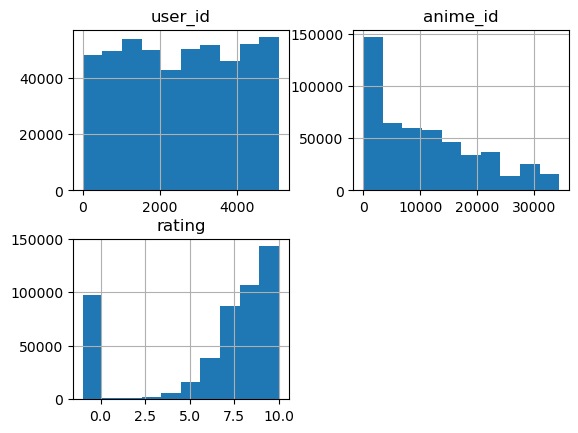

In [72]:
df[:500000].hist();

# Passo 3 - Criando o DataLoader

Devido a biblioteca ```fastai.collab``` temos a função ```CollabDataLoaders``` que possibilita a criação do dataloader de forma muito simples.

Devido ao fato do dataset ser muito grande o treinamento se tornaria inviável. Então a quantidade de dados foi limitada em 500000 amostras.

In [45]:
dls = CollabDataLoaders.from_df(df[:500000], bs=128)
dls.show_batch()

,user_id,anime_id,rating
0,4930,4063,-1
1,1711,11061,10
2,4446,2025,8
3,3476,10087,9
4,1489,18429,-1
5,1456,33161,9
6,3852,19111,-1
7,619,193,6
8,3174,813,8
9,1708,7148,-1


Agora podemos definir a quantidade de usuários e a quantidade de animes.

In [46]:
n_users  = len(dls.classes['user_id'])
n_animes = len(dls.classes['anime_id'])

# Entendendo o Modelo

Vai ser criado uma quantidade x de valores latentes para cada filme e para cada usuário. Inicialmente esse valores possuem valores aleatórios.

In [47]:
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
anime_factors = torch.randn(n_animes, n_factors)

print(user_factors.shape)
print(anime_factors.shape)

torch.Size([5046, 5])
torch.Size([6837, 5])


Em seguida tiramos o produto escalar dos dois tensores (usuário e anime), com isso conseguimos a previsão da nota.

In [83]:
print(f'Valores latentes do primeiro usuário: {user_factors[0]}')
print(f'Valores latentes do primeiro anime: {anime_factors[0]}')

print(f'Previsão da nota: {np.dot(user_factors[0], anime_factors[0])}')

Valores latentes do primeiro usuário: tensor([-0.8631, -0.4292,  0.2788, -0.9665,  0.6088])
Valores latentes do primeiro anime: tensor([-0.1956, -0.6013, -0.1898,  0.2320, -1.3640])
Previsão da nota: -0.6806155443191528


Por fim realizamos o calculo do erro e começamos a ajustar os valores latentes usando o gradiente.

# Passo 4 - Criando os Modelos

## Modelo com Produto Escalar

Inicialmente foi criado um modelo que apenas realiza o produto escalar.

In [48]:
class DotProduct(Module):
    def __init__(self, n_users, n_animes, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.anime_factors = Embedding(n_animes, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        animes = self.anime_factors(x[:,1])
        return (users * animes).sum(dim=1)

Aqui foi realizado a separação entre usuários e filmes das notas. 
* x = [usuário, filme]
* y = [nota]

In [84]:
x,y = dls.one_batch()

Podemos ver as primeiras cinco amostras para entender melhor o dado.

In [50]:
x[:5]

tensor([[2432, 3480],
        [1100, 3221],
        [3159, 4817],
        [ 777, 3974],
        [2251, 1739]])

In [51]:
y[:5]

tensor([[ 8],
        [-1],
        [ 8],
        [ 9],
        [-1]], dtype=torch.int8)

Com tudo pronto criamos o modelo.

In [52]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

Realizamos o treinamento do modelo (Devido a redução no dataset foi possível treinar de forma rápida)

In [53]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,28.179001,26.980362,00:34
1,7.747969,7.750343,00:32
2,6.248377,6.351627,00:34
3,5.825001,6.039006,00:32
4,5.607852,6.000151,00:34


## Modelo com a Função Sigmoid

Agora utilizamos a função sigmoid para limitar as previções para os valores entre 0 e 10.5

In [55]:
class DotProduct_Sigmoid(Module):
    def __init__(self, n_users, n_animes, n_factors, y_range=(0,10.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.anime_factors = Embedding(n_animes, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        animes = self.anime_factors(x[:,1])
        return sigmoid_range((users * animes).sum(dim=1), *self.y_range)

In [56]:
model = DotProduct_Sigmoid(n_users, n_animes, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,5.308864,5.417059,00:29
1,4.499984,4.724598,00:27
2,3.526333,4.456772,00:31
3,2.862518,4.389434,00:26
4,2.423180,4.391400,00:29


## Modelo que Considera o Viés do Usuário e do Anime 

Esse modelo também cria um valor latente que é considerado o viés do usuário/filme, assim ele consegue lidar melhor com animes e usuários que sempre são avaliados ou avaliam da mesma forma.

In [87]:
class DotProductBias(Module):
    def __init__(self, n_users, n_animes, n_factors, y_range=(0,10.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.anime_factors = Embedding(n_animes, n_factors)
        self.anime_bias = Embedding(n_animes, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        animes = self.anime_factors(x[:,1])
        res = (users * animes).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.anime_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [88]:
model = DotProductBias(n_users, n_animes, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,5.234257,5.159613,00:29
1,4.438095,4.556828,00:30
2,3.493392,4.349957,00:28
3,2.804736,4.327622,00:28
4,2.243364,4.335568,00:28


# Passo 5 - Tentando Melhora o Modelo

O modelo que se saiu melhor foi o que considera o viés. Para tentar melhorar ele eu consideiri o valor -1 também, assim ele também tenta descobrir se o usuário assistiu um anime e não avaliou ele.

In [89]:
model = DotProductBias(n_users, n_animes, 50, (-1,10.5))
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,5.102052,5.074093,00:29
1,4.334011,4.444465,00:29
2,3.371844,4.235190,00:28
3,2.535781,4.213607,00:28
4,2.023667,4.220935,00:29


# Deploy do modelo

Foi encontrado o seguinte problema na hora de publicar o modelo no Hugging Face: 

In [ ]:
Traceback (most recent call last):
  File "/home/user/app/app.py", line 29, in <module>
    learn = pickle.load(f)
_pickle.UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

# Conclusão

O melhor modelo foi que utiliza a função sigmoid e o viés, pois ele consegue lidar com os casos de usuários e animes inviesados. Também foi possível perceber que esse tipo de modelo tem um funcionamento bem diferente dos outros que foram estudados na disciplina. E esse foi o primeiro dataset que encontrei um problema com o tamanho do dado, pois quando tentei treinar o modelo com todo o dado ele estimou que iria demorar mais de 20 horas para treinar cada época.